# Investgating the correlations between different models

In [30]:
import pylab as p
import numpy as np
from numpy import *
import pandas as pd
import seaborn as sns
from tqdm import tqdm, trange
from itertools import combinations
from scipy.optimize import minimize
import scipy.cluster.hierarchy as cc
from sklearn.preprocessing import minmax_scale
from sklearn.metrics import log_loss as skl_log_loss
from sklearn.metrics import roc_auc_score as skl_roc_auc_score

### Custom functions

In [2]:
def my_log_loss(ytrue, ypred):
    ll = zeros(6)
    for i in range(6):
        ll[i] = skl_log_loss(ytrue[:,i], ypred[:,i])
    return ll.mean()

def my_correlations(dfs, label='toxic', method='kendall'):
    '''
    Calculate correlations between models.
    
    Arguments:
    dfs = list or array of pandas dataframes; all of the same shape
    label = str, which label or colum to correlate
    method = 'pearson', 'spearman' or 'kendall'
    
    Returns:
    res = two-dimensional numpy array, containing the correlations between the models
    '''
    res = zeros((dfs.shape[0], dfs.shape[0]))
    for i,v in enumerate(tqdm(dfs, desc='Correlations for label: "%s"' %(label))):
        for j,w in enumerate(dfs):
            res[i,j] = dfs[i][label].corr(dfs[j][label], method=method)
    return res


def my_avg_corr(a, b, method='kendall'):
    '''
    Average correlation between all the ycols of two dataframes
    '''
    tmp = zeros(6)
    for i,v in enumerate(ycols):
        tmp[i] = a[v].corr(b[v], method=method)
    return tmp.mean()


def rankavg(arr, axis=0):
    '''
    arr = array_like of ranks to averaged. Result is normalized between (0, 1)
    '''
    tmp  = arr.mean(axis=axis)
    return tmp/tmp.sum()


def my_best_roc(arr, test=None, p=1, verbose=False):
    '''
    My method of averaging arrays such that I get the max roc. 
    Keeps removing models in order to maximize the roc.
    
    Arguments:
    arr = 3d ndarray (n_models, n_samples, n_labels) the input models
    test = like arr, but the test set
    p = int, to use power averages
    verbose = bool, False, whether to print intermediate results.
    
    Returns:
    out = 2d ndarray (n_samples, n_labels), the best average of the models per label
    tout = like out, but the test set
    
    '''

    out = zeros((arr.shape[1], arr.shape[2]))
    
    if test is not None:
        tout = zeros((test.shape[1], test.shape[2]))

    for k in (range(6)):
        # Initialisation params for each label
        indices = arange(arr.shape[0])
        best_v = indices.copy()
        n = len(indices)
        new_best_v = False

        # The label to be analysed in this pass
        ddata = arr[:,:,k]

        # Initial best roc
        r_max = skl_roc_auc_score(ys[:,k], (ddata**p).mean(axis=0))
        if verbose:
            print('Initial best roc value for %s is %.5f' % (ycols[k], r_max))

        # The important stuff happens here
        while n>1:
            # determine the number of combinations
            comb = array(list(combinations(indices, n)))
            # For the combinations, do the thing
            for i,v in enumerate(tqdm(comb, leave=False, desc=ycols[k])):
                m = (ddata[v]**p).mean(axis=0) # average
                r = skl_roc_auc_score(ys[:,k], m) # find roc
                if r > r_max: # check if better than best result so far
#                     print(r, v)
                    r_max = r
                    best_v = v
                    new_best_v = True
            # End of one iteration, update parameters and start over
            if new_best_v:
                indices = best_v
                n = len(best_v)-1
                new_best_v = False
            else:
                n = n-1
                new_best_v = False
        # Announce the best results for a label
        if verbose:
            print(ycols[k], r_max, best_v)
            print()
        # Calculate the mean that gives the highest roc
        out[:,k] = (arr[best_v,:,k]**p).mean(axis=0)
        if test is not None:
            tout[:,k]  = (test[best_v,:,k]**p).mean(axis=0)
        
    if test is not None:
        return out, tout
    else:
        return out

def my_best_roc_rank(arr, test=None, verbose=False):
    '''
    My method of averaging arrays such that I get the max roc. 
    Keeps removing models in order to maximize the roc. Now using ranked average.
    
    Arguments:
    arr = 3d ndarray (n_models, n_samples, n_labels) the input models
    test = like arr, but the test set
    verbose = bool, False, whether to print intermediate results.
    
    Returns:
    out = 2d ndarray (n_samples, n_labels), the best average of the models per label
    tout = like out, but the test set
    
    '''

    out = zeros((arr.shape[1], arr.shape[2]))
    
    if test is not None:
        tout = zeros((test.shape[1], test.shape[2]))

    for k in (range(6)):
        # Initialisation params for each label
        indices = arange(arr.shape[0])
        best_v = indices.copy()
        n = len(indices)
        new_best_v = False

        # The label to be analysed in this pass
        ddata = arr[:,:,k]

        # Initial best roc
        r_max = skl_roc_auc_score(ys[:,k], rankavg(ddata))
        if verbose:
            print('Initial best roc value for %s is %.5f' % (ycols[k], r_max))

        # The important stuff happens here
        while n>1:
            # determine the number of combinations
            comb = array(list(combinations(indices, n)))
            # For the combinations, do the thing
            for i,v in enumerate(tqdm(comb, leave=False, desc=ycols[k])):
                m = rankavg(ddata[v]) # average
                r = skl_roc_auc_score(ys[:,k], m) # find roc
                if r > r_max: # check if better than best result so far
#                     print(r, v)
                    r_max = r
                    best_v = v
                    new_best_v = True
            # End of one iteration, update parameters and start over
            if new_best_v:
                indices = best_v
                n = len(best_v)-1
                new_best_v = False
            else:
                n = n-1
                new_best_v = False
        # Announce the best results for a label
        if verbose:
            print(ycols[k], r_max, best_v)
            print()
        # Calculate the mean that gives the highest roc
        out[:,k] = rankavg(arr[best_v,:,k])
        if test is not None:
            tout[:,k]  = rankavg(test[best_v,:,k])
        
    if test is not None:
        return out, tout
    else:
        return out

### Read in the original data

In [3]:
# Read in the TOXIC competition data
train = pd.read_csv('../data/train.csv')
test = pd.read_csv('../data/test.csv')

# Target labels
ycols = train.columns[2:]
ys = train[ycols].values

print('Reading the challenge data...')
print( '%-27s %-10i' % ('Size of the training set:', len(train)))
print( '%-27s %-10i' % ('Size of the testing set:', len(test)))
print()

Reading the challenge data...
Size of the training set:   159571    
Size of the testing set:    153164    



### Read in the master data file

In [4]:
master_list = pd.read_csv('../xmodel_list.txt', delim_whitespace=True, names=['id', 'logloss', 'roc'], comment='#')

print('Found %i models in the master list.' % len(master_list))

Found 53 models in the master list.


### Reading in the model data

In [5]:
%%time 
# dfs = zeros((len(master_list), train.shape[0], 6))
# dds = zeros((len(master_list), test.shape[0], 6))
dfs = zeros(len(master_list), dtype='O')
dds = zeros(len(master_list), dtype='O')
for i,v in enumerate(tqdm(master_list['id'].values, desc='Loading models...')):
    try:
        dfs[i] = pd.read_csv('../xvalidations/'+v[:-1]+'.csv.bz', compression='bz2')[ycols]#.values
        dds[i] = pd.read_csv('../xsubmissions/'+v[:-1]+'.csv')[ycols]#.values
    except:
        print('Model', v, 'failed to load.')
    

Loading models...: 100%|██████████| 53/53 [00:39<00:00,  1.34it/s]

CPU times: user 37.9 s, sys: 1.51 s, total: 39.4 s
Wall time: 39.4 s


### Trying stuff out

In [6]:
# Get the correlations
corr = {}
for i,v in enumerate(ycols):
    if v=='toxic':
        corr[v] = my_correlations(dfs, label=v, method='kendall')

Correlations for label: "toxic": 100%|██████████| 53/53 [01:28<00:00,  1.67s/it]


In [6]:
# corr = zeros((len(master_list), len(master_list)))
# for i,v in enumerate(tqdm(dfs, desc='Correlating...')):
#     for j,w in enumerate(dfs):
#         corr[i,j] = my_avg_corr(v,w)

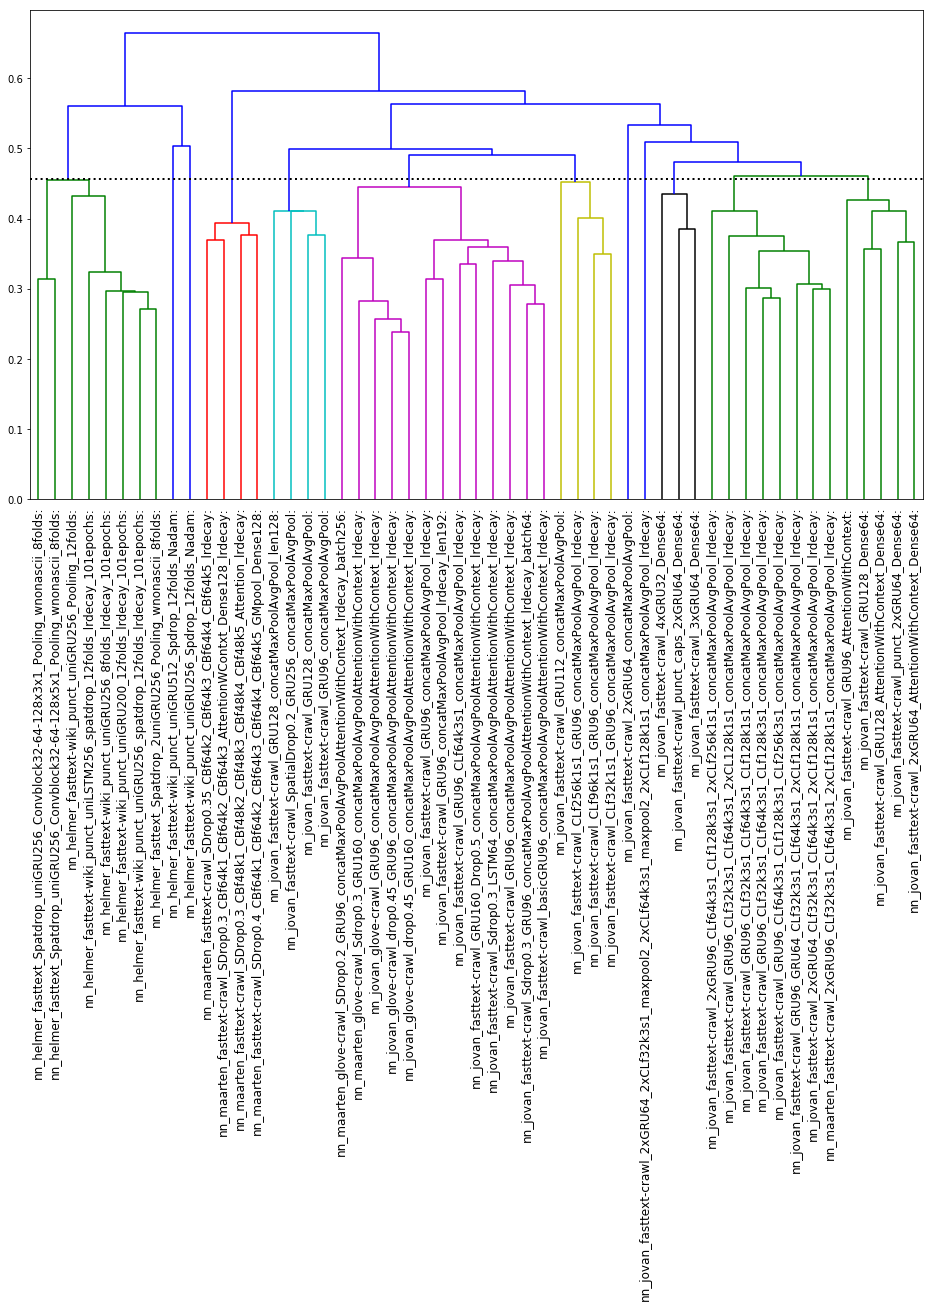

In [7]:
linkage = cc.linkage(corr['toxic'], method='weighted')
p.figure(figsize=(16,9))
dn      = cc.dendrogram(linkage)
order   = array(dn['leaves'])
figga = p.gcf()
ax = figga.axes[0]
ax.set_xticklabels(master_list.id[order], fontsize=12)
# ax.set_xticklabels(arange(len(order))[order], fontsize=12)
p.hlines(y=0.457, xmin=0, xmax=530, linestyles=':', lw=2, color='black')
p.show()

# tmp = corr['toxic'][:, order]
# tmp = tmp[order]

# p.figure(figsize=(12,12))
# p.imshow(tmp, cmap='jet', vmin=0.0, vmax=1)
# p.colorbar(fraction=0.0465, pad=0.02)
# p.xticks(arange(len(order)), order, rotation='vertical', fontsize=12)
# p.yticks(arange(len(order)), order, rotation='horizontal', fontsize=12)
# p.show()

In [8]:
# Finding the clusters: for now assume the clusters are the same per class, and the toxic label defines them well
# clustidx = {}
cls = cc.fcluster(linkage, t=0.457, criterion='distance')

In [9]:
# Create features

# This will store the output features from the averaging of the clusters
train_f = zeros((len(unique(cls)), train.shape[0], ycols.shape[0]))
test_f = zeros((len(unique(cls)),  test.shape[0],  ycols.shape[0]))

# Convert the array of dataframes to a pure ndarray
dfsv = array([i.values for i in dfs])
ddsv = array([i.values for i in dds])

# Here we go...
for i,v in enumerate(unique(cls)):
    idx = arange(len(master_list))[cls==v]
    if len(idx) == 1:
        train_f[i], test_f[i] = dfsv[idx], ddsv[idx]
    else:
        train_f[i], test_f[i] = my_best_roc(arr=dfsv[idx], test=ddsv[idx])


In [78]:
def roc_min_func(weights, models, y):
    fp = 0
    for w, m in zip(weights, models):
        fp += w * m
    return -1*skl_roc_auc_score(y, fp)

In [79]:
%%time

weights = zeros(6, dtype='O')
bestSC  = zeros(6, dtype='O')

for q,v in enumerate(ycols):
    
    print('Finding Blending Weights for', v)
    res_list = []
    weights_list = []

    for i in range(1000):
        starting_values = random.uniform(size=train_f.shape[0])

    #     bounds = [(0, 1)]*len(train_f)
        bounds = [(-1, 1)] * len(train_f)
        res = minimize(roc_min_func,
                       starting_values,
                       args=(train_f[:,:,q], ys[:,q]),
                       method='L-BFGS-B',
                       bounds=bounds,
                       options={'disp': False,
                                'maxiter': 100000})

        res_list.append(res['fun'])
        weights_list.append(res['x'])
    #     print('{iter}\tScore: {score}\tWeights: {weights}'.format(
    #         iter=(i + 1),
    #         score=res['fun'],
    #         weights='\t'.join([str(item) for item in res['x']])))

    bestSC[q] = np.min(res_list)
    bestWght = weights_list[np.argmin(res_list)]
    weights[q] = bestWght

    print('Ensemble Score: {bs}'.format(bs=bestSC[q]))
    print('Best Weights: {ww}'.format(ww=bestWght))
    print()
    
                   

Finding Blending Weights for toxic
Ensemble Score: -0.9890593600807044
Best Weights: [0.56128877 0.44248205 0.4823078  0.12565082 0.89595512 0.43269163
 0.83803795 0.88850199 0.14398474 0.08239229 0.11150382 0.2322898 ]

Finding Blending Weights for severe_toxic
Ensemble Score: -0.9923274068216862
Best Weights: [9.46016758e-01 5.31627210e-02 6.96600419e-01 9.26139256e-01
 5.27649990e-01 9.75866504e-01 7.70067196e-01 6.83044614e-01
 7.24926383e-01 2.56738235e-01 1.11072774e-01 3.28630660e-04]

Finding Blending Weights for obscene
Ensemble Score: -0.995324865849111
Best Weights: [0.73955311 0.10806108 0.1803822  0.21062545 0.17421618 0.69389392
 0.35998746 0.41356348 0.05190516 0.57433697 0.5680697  0.06484528]

Finding Blending Weights for threat
Ensemble Score: -0.9947194973745916
Best Weights: [0.08486731 0.73206667 0.82228038 0.00493735 0.68130037 0.92813001
 0.02034541 0.75737127 0.49391834 0.70927767 0.09520658 0.38345321]

Finding Blending Weights for insult
Ensemble Score: -0.990

In [80]:
res = zeros_like(tmp)
ress = zeros_like(ttmp)
for i,v in enumerate(ycols):
    res[:,i] += average(train_f[:,:,i], weights=weights[i], axis=0)
    ress[:,i] += average(test_f[:,:,i], weights=weights[i], axis=0)
    print('Score for %s: %f' % (v, skl_roc_auc_score(ys[:,i], res[:,i])))
print('Average score:', skl_roc_auc_score(ys, res))

Score for toxic: 0.989059
Score for severe_toxic: 0.992327
Score for obscene: 0.995325
Score for threat: 0.994719
Score for insult: 0.990533
Score for identity_hate: 0.991671
Average score: 0.9922724070041307


In [29]:
tmp, ttmp = my_best_roc(arr=train_f, test=test_f)

In [54]:
for i,v in enumerate(ycols):
    print('Score for %s: %f' % (v, skl_roc_auc_score(ys[:,i], tmp[:,i])))

Score for toxic: 0.989034
Score for severe_toxic: 0.992337
Score for obscene: 0.995312
Score for threat: 0.994740
Score for insult: 0.990540
Score for identity_hate: 0.991728


In [81]:
skl_roc_auc_score(ys, tmp)

0.9922817110668598

### Save predictions, and features to disk

In [67]:
ss = pd.read_csv('../sample_submission.csv')
ss[ycols] = ress
ss.to_csv('./correlated_models_optimized.csv', index=False)

In [38]:
# Train NN features for stacking all the NN models
save('./nn_stack_train.npy', train_f)
# Test NN features for stacking all the NN models
save('./nn_stack_test.npy', test_f)

In [90]:
# The best average prediction, for the next stage (at least temporarily)
tr = pd.DataFrame(tmp, columns='NN'+ycols)
te = pd.DataFrame(ttmp, columns='NN'+ycols)

tr.to_csv('./trainNN.csv.bz2', index=False, compression='bz2')
te.to_csv('./testNN.csv.bz2', index=False, compression='bz2')